# Forecasting
This Notebook reads pre-processed predictor (SWE) and predictand (discharge volumes) data. It then further processes the predictor into principal components using a Principal Component Analysis (PCA). It then uses the principal components as inputs to an Ordinary Least Squares (OLS) regression model to produce ensemble hindcasts (retrospective forecasts) of the predictand. Note that in this workflow we might use the terms forecast and hindcast interchangeably as they would be generated the same way with this method, but either for the future or in hindsight, respectively.

Decisions:
- We use SWE data on the 1st of each month only for forecasting.
- As a result of the PCA design, we assume that we will use all PCs monthly data independently from other months for the forecasting. This is to ensure that we maximize the amount of data we can use each month. E.g., 1st April has more data than 1st November and we would have to drop all the additional data in April if we were to unify the PCA across months, as PCA does not allow for any missing data.
- We use the first SWE principal component only as a predictor for forecasting (see user-specified variables below). If using more PCs, we should be careful with overfitting when the dataset has a few years compared to the number of PCs.
- We use a leave-one-out strategy for cross-validation of the model (see user-specified variables below).
- We use an OLS regression model. This could be replaced with other models in the future.
- We generate ensemble hindcasts with 100 ensemble members (see user-specified variables below).
- The ensemble members are generated with an even distribution (vs. random; see user-specified variables below).

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at input data stationarity.
- We are keeping all data available to build the models, but we could decide to discard extreme years for training the forecast model, as including them could skew the results.

## Modules, settings & functions

In [1]:
# Import required modules
import datetime
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
from pprint import pprint
import rasterio
from rasterio.plot import show
from sklearn.metrics import mean_squared_error
import sys
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2024-10-24 16:48:18,715 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241024_164818.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 4_Forecasting')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-24 16:48:18,952 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../CH_data/CH_input_data/SWE_data.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../CH_data/CH_input_data/nival_basins.shp',
 'domain': '2304',
 'output_data_path': '../CH_data/CH_output_data/',
 'plots_path': '../CH_data/CH_output_plots/',
 'precip_obs_path': '../CH_data/CH_input_data/P_data.nc',
 'streamflow_obs_path': '../CH_data/CH_input_data/Qobs_Camels.nc'}


In [5]:
# Import required functions
from functions import deterministic_forecasting, ensemble_dressing, ensemble_forecasting, leave_out, OLS_model_fitting, principal_component_analysis

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
PC_no_default, PC_id_default = 1, 'PC1'  # integer > 0 for the number of principal components of SWE to use for the forecasting, and string of the PC to use (if PC_no > 1, PC_id should be a list of strings)
target_periods = ['01/01-30/09','01/02-30/09','01/03-30/09','01/04-30/09','01/05-30/09','01/06-30/09','01/07-30/09','01/08-30/09','01/09-30/09']  # target periods for predictand, where each period is described as 'start_DD/start_MM-end_DD/end_MM'
init_dates = ['01/01','01/02','01/03','01/04','01/05','01/06','01/07','01/08','01/09'] # initialization dates for predictor, where each date is described as 'DD/MM'
min_obs_corr_default = 3 # minimum number of observations required to calculate the correlation between predictand-predictor
min_years_overlap_default = 10 # minimum number of years required of predictor-predictand to be able to generate a forecast
nyears_leaveout_default = 1 # number of years to leave out at a time for forecast cross-validation
method_traintest_default = 'leave_out' # method to use for the cross-validation - no other methods are implemented at this stage
ens_size_default = 100  # number of forecast ensemble members to generate
test_target_period = '01/06-30/09'  # target period used for the workflow step-by-step demonstration
test_init_date = '01/05' # initialization date used for the workflow step-by-step demonstration

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'PCs used as predictors for forecasting: {PC_id_default}')
logger.debug(f'forecast target periods: {target_periods}')
logger.debug(f'forecast initialization dates: {init_dates}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of predictor-predictand for forecast generation: {min_years_overlap_default}')
logger.debug(f'number of years left out at a time for cross-validation: {nyears_leaveout_default}')
logger.debug(f'forecast ensemble size: {ens_size_default}')

## Read data

In [8]:
# Read pre-processed predictand data & format to Pandas DataFrame for forecasting
predictand_ds = xr.open_dataset(settings['output_data_path']+"Vol_1979_2021_basin"+test_basin_id+".nc")
predictand_da = predictand_ds.sel(Station_ID=test_basin_id)
predictand_df = predictand_da.to_dataframe().reset_index().drop(columns=['lat','lon','source','Station_ID']).set_index('year')

display(predictand_df.head())

,Vol_1Jan-30Sep,Vol_1Feb-30Sep,Vol_1Mar-30Sep,Vol_1Apr-30Sep,Vol_1May-30Sep,Vol_1Jun-30Sep,Vol_1Jul-30Sep,Vol_1Aug-30Sep,Vol_1Sep-30Sep
year,,,,,,,,,
1981,34853587.2,33672240.0,32795020.8,31708627.2,27781747.2,22004956.8,13364352.0,6677164.8,2942870.4
1982,30788380.8,29497392.0,28530316.8,27532828.8,25864790.4,19333555.2,10986537.6,6583680.0,3424377.6
1983,36158054.4,34431609.6,33207580.8,32039625.6,30233692.8,22385116.8,12645158.4,5756918.4,2608416.0
1984,27503625.6,26568000.0,25776576.0,25032844.8,24126681.6,19869148.8,10542700.8,4970332.8,2702419.2
1985,28471651.2,27523843.2,26850700.8,26096428.8,25057728.0,18698601.6,11802585.6,6954940.8,2311977.6


Note: We're only showing the first few rows of data, otherwise it takes too much space. Same for the predictors below.

In [9]:
# Read pre-processed predictor data for basin of interest & format to Pandas DataFrame for forecasting
predictor_ds = xr.open_dataset(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc")
predictor_df = predictor_ds.to_dataframe().drop(columns=['flag','donor_stations','lat','lon','station_name']).unstack(level='station_id')
predictor_df.columns = predictor_df.columns.droplevel()

display(predictor_df.head())

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
time,,,,,,,,,,,,,,,,,,,,,
1996-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Diese zelle obere neu von LNU für camels SWE daten
#predictor_ds = xr.open_dataset(settings['output_data_path']+"SWE_Camels_"+test_basin_id+".nc")
#predictor_df = predictor_ds.to_dataframe().drop(columns=['lat','lon','station_name']).unstack(level='station_id')
#predictor_df.columns = predictor_df.columns.droplevel()

#display(predictor_df.head())
#display(predictor_df)

## Hindcast generation

### Workflow step-by-step demonstration
Let's go over the forecasting steps for a test forecast start date and target period to see how it works.

In [11]:
# Define initialization date for which to produce hindcasts
init_day, init_month = int(test_init_date[0:2]), int(test_init_date[3:5])
init_month_name = datetime.datetime.strptime(str(init_month), "%m").strftime("%b")
    
# Define target period for which to produce hindcasts
target_start_day, target_start_month = int(test_target_period[0:2]), int(test_target_period[3:5])
target_end_day, target_end_month = int(test_target_period[6:8]), int(test_target_period[9:11])
target_start_month_name = datetime.datetime.strptime(str(target_start_month), "%m").strftime("%b")
target_end_month_name = datetime.datetime.strptime(str(target_end_month), "%m").strftime("%b")

print("We will generate hindcasts initialized on",init_day, init_month_name, "for the target period", target_start_day, target_start_month_name,"-",target_end_day,target_end_month_name,".")

We will generate hindcasts initialized on 1 May for the target period 1 Jun - 30 Sep .


In [12]:
# Select predictor of interest
predictor_subset_df = predictor_df[(predictor_df.index.month == init_month) & (predictor_df.index.day == init_day)]

display(predictor_subset_df.head())

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
time,,,,,,,,,,,,,,,,,,,,,
1997-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,307.060,NaN,NaN,369.900,332.400,340.790,289.580,350.260,459.490
1998-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,220.160,NaN,NaN,271.670,237.630,260.190,199.600,243.530,336.170
1999-05-01,250.843,343.233,472.974,195.290,364.914,325.373,350.785,252.967,148.807,263.536,...,453.720,468.383,361.539,511.927,569.506,545.092,503.090,490.780,580.027,686.305
2000-05-01,153.886,211.585,307.021,106.374,223.449,201.645,217.003,143.219,71.089,171.560,...,269.106,311.837,226.510,295.423,369.224,316.239,364.807,295.216,352.330,496.420
2001-05-01,474.918,588.887,707.518,389.433,592.592,544.641,546.906,456.316,341.620,466.542,...,592.516,636.163,523.478,659.868,750.046,686.137,710.954,623.727,731.070,925.374


Note: Again here we're only showing the first few rows of data, otherwise it takes too much space. Same for the predictand below.

In [13]:
# Select predictand of interest
predictand_subset_df = predictand_df['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

display(predictand_subset_df.head())

year
1981    22004956.8
1982    19333555.2
1983    22385116.8
1984    19869148.8
1985    18698601.6
Name: Vol_1Jun-30Sep, dtype: float64

In [14]:
# Clean predictor and predictand datasets and find the number of overlapping years with data
cleaned_predictor_data = predictor_subset_df.dropna(axis=1,thresh=min_years_overlap_default).dropna(axis=0,how='any')
cleaned_predictand_data = predictand_subset_df.dropna()

if (cleaned_predictor_data.empty == False) and (cleaned_predictand_data.empty == False):
    cleaned_predictor_data_years = cleaned_predictor_data.index.year.values
    cleaned_predictand_data_years = cleaned_predictand_data.index.values
    overlapping_years = list(set(cleaned_predictor_data_years) & set(cleaned_predictand_data_years))
    overlapping_years.sort()
else:
    overlapping_years = []
    
overlapping_predictor_data = cleaned_predictor_data[cleaned_predictor_data.index.year.isin(overlapping_years)]
overlapping_predictand_data = predictand_subset_df.loc[overlapping_years]
    
print("There are",str(len(overlapping_years)),"overlapping years with data between the predictors and the predictand for this starting date-target period combination.")
display(overlapping_predictor_data)
display(overlapping_predictand_data)

There are 22 overlapping years with data between the predictors and the predictand for this starting date-target period combination.


station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
time,,,,,,,,,,,,,,,,,,,,,
1999-05-01,250.843,343.233,472.974,195.290,364.914,325.373,350.785,252.967,148.807,263.536,...,453.720,468.383,361.539,511.927,569.506,545.092,503.090,490.780,580.027,686.305
2000-05-01,153.886,211.585,307.021,106.374,223.449,201.645,217.003,143.219,71.089,171.560,...,269.106,311.837,226.510,295.423,369.224,316.239,364.807,295.216,352.330,496.420
2001-05-01,474.918,588.887,707.518,389.433,592.592,544.641,546.906,456.316,341.620,466.542,...,592.516,636.163,523.478,659.868,750.046,686.137,710.954,623.727,731.070,925.374
2002-05-01,94.907,182.781,248.280,51.415,197.738,181.871,182.721,74.788,24.695,141.715,...,240.369,229.663,184.625,272.296,282.649,280.326,257.347,244.622,289.023,337.543
2003-05-01,145.145,291.881,503.429,70.975,321.731,284.983,298.214,101.796,18.852,194.332,...,392.950,454.844,233.289,441.672,531.950,479.669,488.430,428.828,516.172,657.450
2004-05-01,203.605,309.339,412.561,134.411,335.077,305.188,314.152,193.978,90.911,252.152,...,371.180,367.340,286.029,417.394,446.361,430.297,398.818,382.760,455.416,534.808
2005-05-01,38.096,77.140,197.090,18.572,98.508,90.486,95.967,31.646,7.929,68.600,...,150.974,191.038,92.180,165.342,225.800,191.683,218.101,180.459,214.264,294.581
2006-05-01,118.862,176.586,273.126,80.936,193.849,174.971,184.866,116.225,64.341,141.047,...,249.109,254.043,183.200,273.890,306.779,281.960,288.837,258.931,304.930,383.354
2007-05-01,6.194,14.777,85.778,1.595,23.852,24.960,26.457,3.602,0.579,20.288,...,64.154,100.072,21.994,67.229,120.744,82.680,134.469,80.449,101.528,184.819


year
1999    19559577.6
2000    15182035.2
2001    23724835.2
2002    12268540.8
2003    10541750.4
2004    14031360.0
2005     7555248.0
2006    12067660.8
2007     9622368.0
2008    20902924.8
2009    14211849.6
2010    14358297.6
2011    11552198.4
2012    13435372.8
2013    12317961.6
2014    15714604.8
2015    11538288.0
2016    17126899.2
2017    11844835.2
2018    11611555.2
2019    20693664.0
2020    12330144.0
Name: Vol_1Jun-30Sep, dtype: float64

We need a minimum number of years of data to be able to produce reliable hindcasts. min_years_overlap_default defines the minimum number of years requires. If this condition is met, we can proceed with the forecasting steps below.

We now run a Principal Component Analysis (PCA), a statistical method used to transform a set of intercorrelated variables into an equal number of uncorrelated variables. This step becomes particularly essential after gap filling, which might have introduced additional correlation across the SWE stations.

In [15]:
# Run PCA
PCs, loadings, fig = principal_component_analysis(overlapping_predictor_data, flag=1)

<IPython.core.display.Javascript object>

This plot shows the variance in the predictor data (gap-filled SWE stations observations) captured by each principal component. Where the captured variance decreases with each new PC. For the Bow at Banff, we can see that the first principal component captures more than 90% of the variance. We will therefore use PC1 as the sole predictor for the rest of the forecasting process.

In [16]:
# Plot PC1 vs. each stations' SWE
if len(overlapping_predictor_data.columns) < 5:
    fig, ax = plt.subplots(1,len(overlapping_predictor_data.columns), figsize=[9,2])
    col = -1
    for s in range(len(overlapping_predictor_data.columns)):
        col += 1
        ax[col].scatter(overlapping_predictor_data.iloc[:,s], PCs['PC1'], color='b', alpha=.3) 
        ax[col].tick_params(axis='x', labelsize=8)
        ax[col].tick_params(axis='y', labelsize=8)
        ax[col].set_xlabel(overlapping_predictor_data.columns[s], fontweight='bold')
    ax[0].set_ylabel('PC1', fontweight='bold')
    plt.tight_layout();
    
elif len(overlapping_predictor_data.columns) > 4:
    nrow = int(len(overlapping_predictor_data.columns)/4)
    ncol = 4
    if len(overlapping_predictor_data.columns)%4 != 0:
        nrow += 1
    fig, ax = plt.subplots(nrow,ncol, figsize=[9,2*nrow])
    row = 0
    col = -1
    for s in range(len(overlapping_predictor_data.columns)):
        col += 1
        if col == ncol:
            row += 1
            col = 0
        ax[row,col].scatter(overlapping_predictor_data.iloc[:,s], PCs['PC1'], color='b', alpha=.3) 
        ax[row,col].tick_params(axis='x', labelsize=8)
        ax[row,col].tick_params(axis='y', labelsize=8)
        ax[row,col].set_xlabel(overlapping_predictor_data.columns[s], fontweight='bold')
    for r in range(nrow):
        ax[r,0].set_ylabel('PC1', fontweight='bold')
    empties = 4*nrow - len(overlapping_predictor_data.columns)
    for c in range(ncol-empties, ncol):
        fig.delaxes(ax[nrow-1,c]);
    plt.tight_layout();

<IPython.core.display.Javascript object>

This plot shows how well PC1 correlates with each individual station observations. Note than the correlations can be negative due to the SWE observations being standardized prior to the PCA. This however should not impact the next forecasting steps. Let's have a look at the spatial patterns in these correlations now.

In [17]:
# Make map of PCA loadings (correlation between stations & PCs data)
# Note that this takes a few seconds to plot as it needs to load the DEM

# Load DEM
src = rasterio.open(settings['basins_dem_path']+test_basin_id+".tif")

# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.Station_ID == test_basin_id]

# Add basin contour & elevation shading to map
shp_testbasin_gdf.plot(edgecolor='k', facecolor='none', lw=.5)
rasterio.plot.show((src, 1), cmap='Greys', vmin=0, alpha=.7)

# Extract geospatial information for stations to plot
SWE_stations_geos = predictor_ds.sel(station_id=loadings.columns)

# plot data
#sc = plt.scatter(SWE_stations_geos.lon.values, SWE_stations_geos.lat.values, c=loadings.loc['PC1'].values, cmap='rocket_r')
sc = plt.scatter(SWE_stations_geos.lon.values, SWE_stations_geos.lat.values, c=loadings.loc['PC1'].values, cmap='viridis')

# Remove frame ticks
plt.xticks([])
plt.yticks([])

# Add colorbar
cbar = plt.colorbar(sc, fraction=.03)
cbar.set_label('R$^2$');

RasterioIOError: ../test_case_data/input_data/MERIT_Hydro_dem_2304.tif: No such file or directory

We can see some spatial patterns in the signal picked up by PC1 across the river basin. We now plot a timeseries of all PCs and of the predictand to see what the temporal patterns are.

<IPython.core.display.Javascript object>


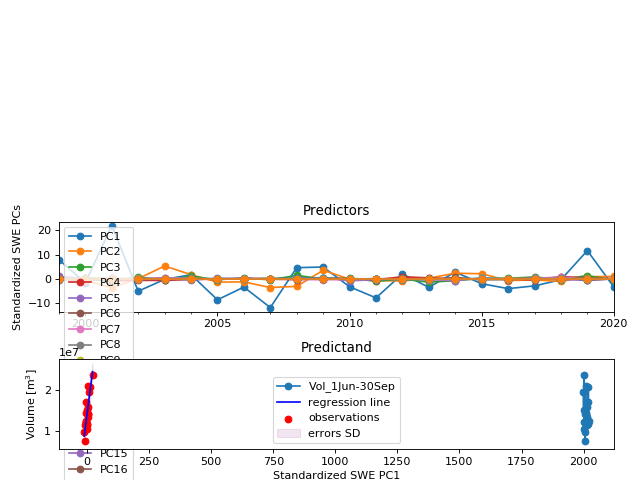

In [18]:
# Plot all PCs and the predictand
fig, ax = plt.subplots(2, 1, figsize=(8,6))
for pc in range(len(PCs.columns)):
    PCs.iloc[:,pc].plot(ax=ax[0], marker='o', label=PCs.iloc[:,pc].name)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Standardized SWE PCs')
ax[0].legend()
ax[0].set_title('Predictors')
overlapping_predictand_data.plot(ax=ax[1], marker='o')
ax[1].set_xlabel('')
ax[1].set_ylabel('Volumes [m$^3$]')
ax[1].set_title('Predictand')
plt.tight_layout();

This plot helps us understand check visually whether the PCs and the predictand follow a similar temporal behavior visually. We can see for the Bow River at Banff how PC1 has a clear signal that fluctuates over time, while the other PCs seem to have smaller values that are more noisy.

In [19]:
# Combine the PCs and the predictand into a single DataFrame for forecasting
combined_df = PCs.reset_index(drop=True)
combined_df['year'] = overlapping_years
combined_df = combined_df.set_index('year')
combined_df['Vol'] = overlapping_predictand_data

display(combined_df.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,Vol
year,,,,,,,,,,,,,,,,,,,,,
1999,7.896695,-0.203796,-0.256671,0.667737,1.001542,-0.227885,-0.315983,0.017522,-0.237653,-0.160032,...,-0.027649,-0.026464,-0.023336,-0.014993,-0.009015,-0.012339,0.001982,0.001359,4.012186e-16,19559577.6
2000,-1.605143,-0.694530,0.360227,0.304498,0.112527,-0.588300,0.125688,0.568988,0.181610,-0.089851,...,0.002636,0.000776,-0.003496,-0.050453,-0.002011,0.009715,-0.014864,0.006283,4.012186e-16,15182035.2
2001,21.856029,-3.554721,-1.419220,-0.856366,-0.026008,-0.021176,0.196309,-0.038073,0.051742,0.034780,...,0.001875,0.007422,0.000802,0.002803,-0.003145,-0.001262,0.003432,-0.003247,4.012186e-16,23724835.2
2002,-5.047210,0.102956,0.815413,-0.600772,0.213186,0.290073,-0.157882,-0.144689,0.178614,-0.200803,...,0.029439,-0.021045,0.003539,0.045489,-0.025575,0.006853,-0.021217,-0.032816,4.012186e-16,12268540.8
2003,-0.186844,5.287112,-0.633447,-0.626142,0.302247,-0.298293,0.453992,0.036286,-0.036486,-0.112472,...,0.074178,0.001167,0.018901,0.019327,0.027639,-0.003463,-0.001037,0.010003,4.012186e-16,10541750.4


We will now go over the model building and ensemble dressing steps in cross-validation mode. We will only print out the outputs for the last year left out and predicted for illustrative purposes.

In [20]:
# Split the timeseries into training and validation timeseries for forecasting
train_data_dict, test_data_dict = leave_out(combined_df, nyears_leaveout_default)

# Loop over the samples
for s in list(train_data_dict.keys()):

    # Select train and test data
    train_data = train_data_dict[s]
    test_data = test_data_dict[s]

    # Fit the model on the training data
    OLS_model = OLS_model_fitting(PC_id_default, train_data)

    # Perform out-of-sample deterministic forecasting for the testing period
    fc_det = deterministic_forecasting(OLS_model, test_data)

    # Calculate errors standard deviation for the training period
    fc_det_train = deterministic_forecasting(OLS_model, train_data)
    rmse = mean_squared_error(train_data['Vol'].values, fc_det_train['Vol_fc_mean'].values, squared=False)

    # generate ensembles
    fc_ens = ensemble_dressing(fc_det, rmse, ens_size=ens_size_default)

    # append all ensembles generated for each moving window
    if s == 0:
        fc_ens_df = fc_ens
    else:
        fc_ens_df = pd.concat([fc_ens_df,fc_ens])

In [21]:
# Print a summary of the model
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Vol   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     48.20
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.29e-06
Time:                        16:48:54   Log-Likelihood:                -335.76
No. Observations:                  21   AIC:                             675.5
Df Residuals:                      19   BIC:                             677.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.421e+07   4.88e+05     29.125      0.0

For a breakfown of what the regression results mean, see this [post](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a).

In [22]:
# Plot the predictor, predictand & the errors standard deviation for the training period
sorted_data = fc_det_train.sort_values(by='Vol_fc_mean')
plt.scatter(train_data[PC_id_default], train_data['Vol'], color='r', label='observations')
plt.plot(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean'], color='b', label='regression line')
plt.fill_between(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean']+rmse, sorted_data['Vol_fc_mean']-rmse, color='purple', alpha=.1, label='errors SD')
plt.xlabel('Standardized SWE PC1')
plt.ylabel('Volume [m$^3$]')
plt.legend();

The shaded area shows the Standard Deviation (SD) of the errors between the observations and the regression line. This is used to generate ensembles around the deterministic forecast for the year left out, by drawing random samples from a normal (Gaussian) distribution within this space.

<IPython.core.display.Javascript object>


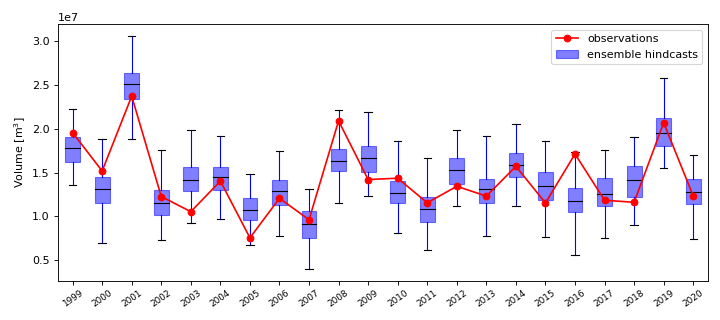

In [23]:
# Plot timeseries of ensemble hindcasts and observations
fig = plt.figure(figsize=(9,4))
ts_ax = plt.subplot()
obs, = ts_ax.plot(np.arange(1, len(overlapping_predictand_data.index)+1), overlapping_predictand_data.values, color='red', label='observations', marker='o')
bp = plt.boxplot(np.transpose(fc_ens_df.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
plt.setp(bp['boxes'], color='b', alpha=.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')
bluepatch = mpatches.Patch(color='b', alpha=.5, label='ensemble hindcasts')
ts_ax.set_ylabel('Volume [m$^3$]')
ts_ax.set_xticks(np.arange(1, len(overlapping_predictand_data.index)+1))
ts_ax.set_xticklabels(overlapping_predictand_data.index.values, rotation=35, fontsize=8)
plt.legend(handles=[obs,bluepatch])
plt.tight_layout();

### Generate all hindcasts
We now generate hindcasts for all combinations of forecast initialization dates and target periods.

In [24]:
# Ensemble forecasting

counter = 0

for i in init_dates:

    for p in target_periods:

        # Define initialization date for which to produce hindcasts
        init_day, init_month = int(i[0:2]), int(i[3:5])

        # Define target period for which to produce hindcasts
        target_start_day, target_start_month = int(p[0:2]), int(p[3:5])
        target_end_day, target_end_month = int(p[6:8]), int(p[9:11])
        target_start_month_name = datetime.datetime.strptime(str(target_start_month), "%m").strftime("%b")
        target_end_month_name = datetime.datetime.strptime(str(target_end_month), "%m").strftime("%b")

        # Check that the target period starts after the initialization date so we can proceed with the hindcasting
        # Note: We assume that the initialization date and target period are both in the same year. No cross-year forecasting
        if (target_start_month > init_month) or ((target_start_month == init_month) & (target_start_day >= init_day)):

            counter += 1
            
            # Select predictor of interest
            predictor_subset_df = predictor_df[(predictor_df.index.month == init_month) & (predictor_df.index.day == init_day)]

            # Select predictand of interest
            predictand_subset_df = predictand_df['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

            # Generate ensemble hindcasts
            ens_hindcasts_df = ensemble_forecasting(predictor_subset_df, predictand_subset_df, PC_ids=PC_id_default, ens_size=ens_size_default, min_overlap_years=min_years_overlap_default, method_traintest=method_traintest_default, nyears_leaveout=nyears_leaveout_default)

            # Save ensemble hindcasts to xarray DataArray
            if ens_hindcasts_df is not None:
                switch = 1
                ens_hindcasts_da = xr.DataArray(data=ens_hindcasts_df.to_numpy().reshape((ens_hindcasts_df.to_numpy().shape[0], ens_hindcasts_df.to_numpy().shape[1], 1)), coords={'year':ens_hindcasts_df.index,'ens_member':ens_hindcasts_df.columns,'init_date':[i]}, dims=['year','ens_member','init_date'], name='Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name)
            else:
                ens_hindcasts_da = xr.DataArray(data=np.reshape([np.nan]*ens_size_default,(1,ens_size_default,1)), coords={'year':[2000],'ens_member':np.arange(1,ens_size_default+1),'init_date':[i]}, dims=['year','ens_member','init_date'], name='Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name)
            ens_hindcasts_da.attrs['long_name'] = 'Ensemble volume hindcasts'
            ens_hindcasts_da.attrs['info'] = 'Ensemble hindcasts of '+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name+' volumes in basin '+test_basin_id+'. The hindcasts are generated using an Ordinary Least Squares (OLS) regression model, intialized with principal components ('+PC_id_default+') of gap filled SWE station observations on init_date as predictors.'
            ens_hindcasts_da.attrs['units'] = 'm3'

            # Save ensemble hindcasts to xarray Dataset
            if counter == 1:
                ens_hindcasts_ds = ens_hindcasts_da
            else:
                ens_hindcasts_ds = xr.merge([ens_hindcasts_ds, ens_hindcasts_da])

    # Add information to the Dataset
    ens_hindcasts_ds.init_date.attrs['long_name'] = 'Hindcast initialization date'
    ens_hindcasts_ds.init_date.attrs['info'] = 'DD/MM of the predictors used to generate the hindcasts.'
    ens_hindcasts_ds.ens_member.attrs['long_name'] = 'Ensemble member'
    
display(ens_hindcasts_ds)

<xarray.Dataset>
Dimensions:         (ens_member: 100, init_date: 9, year: 23)
Coordinates:
  * init_date       (init_date) object '01/01' '01/02' ... '01/08' '01/09'
  * year            (year) int64 1998 1999 2000 2001 ... 2017 2018 2019 2020
  * ens_member      (ens_member) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
Data variables:
    Vol_1Jan-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Feb-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Mar-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Apr-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1May-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Jun-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Jul-30Sep  (year, ens_member, init_date) float64 nan nan ... nan nan
    Vol_1Aug-30Sep  (year, ens_member, init_date) float64 nan nan ... nan
    Vol_1Sep-30Sep  (year, ens_member, init_date) float64 nan nan ... 1.674e+06

## Save data
Save the output hindcasts so we can read them in other Notebooks.

In [25]:
# Save the data
ens_hindcasts_ds.to_netcdf(settings['output_data_path']+'ensemble_hindcasts_basin'+test_basin_id+'.nc', format="NETCDF4")

We can optionally store each model used to generate these hindcasts using the following code: model_fit.save('OLS_model.pkl', remove_data=False)
To load model back we would do: loaded = sm.load('OLS_model.pkl')
Note that a unique model is built for each initialization date - target period combination, but also for each year left out.